## setup

In [1]:
import os, cv2, shutil, heapq, random, tempfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from multiprocessing import Pool
from collections import Counter, defaultdict
from skimage.metrics import mean_squared_error
from skimage.transform import resize
from concurrent.futures import ThreadPoolExecutor

random.seed(0)

In [2]:
class DataProcessor:

    def __init__(self):
        """Initialize the DataProcessor class."""
        # Common image file extensions
        self.image_extensions = ('.jpg', '.jpeg', '.png')
        self.mask_extension = ".png"

    def get_all_images(self, folder_path, recursive=True):
        """
        Find all image files in the given folder path and optionally its subfolders.
        
        Args:
            folder_path (str): Path to the folder to search for images
            recursive (bool): Whether to include subfolders in the search (default: True)
            
        Returns:
            list: List of full paths to all image files found
        """
        # Validate input path
        if not os.path.isdir(folder_path):
            raise ValueError(f"The path {folder_path} is not a valid directory")
            
        image_files = []
        
        # Helper function to check if a file is an image based on extension
        def is_image_file(filename):
            return any(filename.lower().endswith(ext) for ext in self.image_extensions)
        
        # Walk through the directory structure
        if recursive:
            # Use os.walk to traverse the directory tree
            for root, _, files in os.walk(folder_path):
                for filename in files:
                    if is_image_file(filename):
                        full_path = os.path.join(root, filename)
                        image_files.append(full_path)
        else:
            # Only look at files in the top directory
            for filename in os.listdir(folder_path):
                full_path = os.path.join(folder_path, filename)
                if os.path.isfile(full_path) and is_image_file(filename):
                    image_files.append(full_path)
                    
        return image_files

    def get_all_files(self, folder_path, recursive=True):
        """
        Find all image files in the given folder path and optionally its subfolders.
        
        Args:
            folder_path (str): Path to the folder to search for images
            recursive (bool): Whether to include subfolders in the search (default: True)
            
        Returns:
            list: List of full paths to all image files found
        """
        # Validate input path
        if not os.path.isdir(folder_path):
            raise ValueError(f"The path {folder_path} is not a valid directory")
            
        files = []
        
        # Walk through the directory structure
        if recursive:
            # Use os.walk to traverse the directory tree
            for root, _, files in os.walk(folder_path):
                for filename in files:
                    full_path = os.path.join(root, filename)
                    files.append(full_path)
        else:
            # Only look at files in the top directory
            for filename in os.listdir(folder_path):
                full_path = os.path.join(folder_path, filename)
                if os.path.isfile(full_path):
                    files.append(full_path)
                    
        return files


    def crop_to_square(self, folder_path, recursive=True):
        """
        Crop all images in the folder to make them square.
        The crop is centered on the image.
        Overwrites the original images with the cropped versions.
        
        Args:
            folder_path (str): Path to the folder containing images
            recursive (bool): Whether to include subfolders (default: True)
            
        Returns:
            dict: Summary of operations performed
        """
        # Get all images in the folder
        image_paths = self.get_all_images(folder_path, recursive)
        
        stats = {
            "processed": 0,
            "errors": 0,
            "skipped": 0,  # Images that are already square
            "total": len(image_paths)
        }
        
        with Pool() as pool:
            results = pool.map(self._process_crop_image, image_paths)
        
        stats["processed"] = results.count('processed')
        stats["skipped"] = results.count('skipped')
        stats["errors"] = results.count('error')
        
        print(f"Square crop operation completed.")
        print(f"Processed: {stats['processed']}, Skipped (already square): {stats['skipped']}, Errors: {stats['errors']}")
        return stats
    
    def _process_crop_image(self, path):
        try:
            with Image.open(path) as img:
                width, height = img.size
                
                # Skip if already square
                if width == height:
                    return 'skipped'
                
                # Determine the size of the square
                size = min(width, height)
                
                # Calculate coordinates for center crop
                left = (width - size) // 2
                top = (height - size) // 2
                right = left + size
                bottom = top + size
                
                # Crop the image
                cropped_img = img.crop((left, top, right, bottom))
                
                # Save back to the same file, preserving format
                cropped_img.save(path, format=img.format)
                return 'processed'
                
        except Exception as e:
            print(f"Error processing {path}: {str(e)}")
            return 'error'


    def scale_images(self, folder_path, target_resolution, recursive=True):
        """
        Scale images in the given folder to the specified resolution using Lanczos resampling.
        Always overwrites the original images with their scaled versions.
        
        Args:
            folder_path (str): Path to the folder containing images
            target_resolution (tuple): Target resolution as (width, height) in pixels
            recursive (bool): Whether to include subfolders (default: True)
                
        Returns:
            dict: Summary of operations performed
        """
        # Get all images in the folder
        image_paths = self.get_all_images(folder_path, recursive)
        
        stats = {
            "processed": 0,
            "errors": 0,
            "skipped": 0,  # Images that are already at the target resolution
            "total": len(image_paths)
        }
        
        # Prepare arguments for each image path
        args = [(path, target_resolution) for path in image_paths]
        
        with Pool() as pool:
            results = pool.starmap(self._process_scale_image, args)
        
        stats["processed"] = results.count('processed')
        stats["skipped"] = results.count('skipped')
        stats["errors"] = results.count('error')
        
        print(f"Scale operation completed.")
        print(f"Processed: {stats['processed']}, Skipped (already at target resolution): {stats['skipped']}, Errors: {stats['errors']}")
        return stats

    def _process_scale_image(scale,path, target_resolution):
        target_width, target_height = target_resolution
        try:
            with Image.open(path) as img:
                original_width, original_height = img.size
                
                # Skip if already at target resolution
                if original_width == target_width and original_height == target_height:
                    return 'skipped'
                
                # Resize using Lanczos resampling to exact target dimensions
                resized_img = img.resize((target_width, target_height), Image.LANCZOS)
                
                # Save the resized image, overwriting the original and preserving format
                resized_img.save(path, format=img.format)
                return 'processed'
                
        except Exception as e:
            print(f"Error processing {path}: {str(e)}")
            return 'error'


    def get_summary(self, folder_path, recursive=True):
        """
        Generate a comprehensive summary of images in the given folder.
        
        Args:
            folder_path (str): Path to the folder containing images
            recursive (bool): Whether to include subfolders (default: True)
            
        Returns:
            dict: Summary information about the images
        """
        # Get all images in the folder
        image_paths = self.get_all_images(folder_path, recursive)
        
        if not image_paths:
            return {"error": "No images found in the specified folder"}
        
        # Initialize counters and data structures
        total_images = len(image_paths)
        total_size_bytes = 0
        resolutions = Counter()
        aspect_ratios = Counter()
        formats = Counter()
        sizes = []
        errors = []
        
        # Process each image
        for path in image_paths:
            try:
                # Get file size
                file_size = os.path.getsize(path)
                total_size_bytes += file_size
                sizes.append(file_size)
                
                # Open and analyze the image
                with Image.open(path) as img:
                    width, height = img.size
                    
                    # Resolution
                    resolution = f"{width}x{height}"
                    resolutions[resolution] += 1
                    
                    # Format
                    if img.format:
                        formats[img.format] += 1
                    else:
                        formats["Unknown"] += 1
                    
                    # Aspect ratio (rounded to 2 decimal places)
                    if height > 0:
                        ratio = round(width / height, 2)
                        aspect_ratios[ratio] += 1
                    
            except Exception as e:
                errors.append({"path": path, "error": str(e)})
        
        # Calculate statistics
        successful_images = total_images - len(errors)
        
        # Size statistics (in MB)
        if sizes:
            avg_size_mb = sum(sizes) / len(sizes) / (1024 * 1024)
            min_size_mb = min(sizes) / (1024 * 1024)
            max_size_mb = max(sizes) / (1024 * 1024)
            total_size_mb = total_size_bytes / (1024 * 1024)
        else:
            avg_size_mb = min_size_mb = max_size_mb = total_size_mb = 0
        
        # Most common attributes
        most_common_resolution = resolutions.most_common(1)[0] if resolutions else None
        most_common_aspect = aspect_ratios.most_common(1)[0] if aspect_ratios else None
        
        # Prepare summary
        summary = {
            "total_images": total_images,
            "successful_analyses": successful_images,
            "errors": len(errors),
            "error_details": errors if errors else None,
            
            "size_stats": {
                "total_size_mb": round(total_size_mb, 2),
                "average_size_mb": round(avg_size_mb, 2),
                "min_size_mb": round(min_size_mb, 2),
                "max_size_mb": round(max_size_mb, 2)
            },
            
            "resolutions": {
                "most_common": most_common_resolution,
                "all": dict(resolutions.most_common())
            },
            
            "formats": dict(formats.most_common()),
            
            "aspect_ratios": {
                "most_common": most_common_aspect,
                "all": dict(aspect_ratios.most_common(10))
            }
        }
        
        # Print a summary report (without Orientation, Color modes, and Dimension statistics)
        print("\n=== IMAGE SUMMARY REPORT ===")
        print(f"Total images analyzed: {total_images}")
        print(f"Successful: {successful_images}, Errors: {len(errors)}")
        print(f"Total size: {round(total_size_mb, 2)} MB")
        print("\nResolutions:")
        for res, count in resolutions.most_common(5):
            print(f"  {res}: {count} images ({round(count/total_images*100, 1)}%)")
        print(f"  ... and {len(resolutions) - 5} more resolutions") if len(resolutions) > 5 else None
        
        print("\nFormats:")
        for fmt, count in formats.most_common():
            print(f"  {fmt}: {count} images ({round(count/total_images*100, 1)}%)")
        
        return summary


    def generate_object_density_data(self, folder_path, recursive=True):
        """
        Generate object density data from mask images in a given folder.

        Args:
            folder_path (str): Path to the folder containing object masks.
            recursive (bool): Whether to include subfolders (default: True).

        Returns:
            dict: Contains density map, number of masks, and image dimensions.
        """
        mask_paths = self.get_all_images(folder_path, recursive)
        
        if not mask_paths:
            return {"error": "No mask images found in the specified folder"}
        
        # Load the first mask to get image dimensions
        with Image.open(mask_paths[0]) as img:
            width, height = img.size

        # Initialize the density map
        density_map = np.zeros((height, width), dtype=np.uint32)

        # Process each mask image
        for path in mask_paths:
            try:
                with Image.open(path) as img:
                    img = img.convert('L')
                    img_array = np.array(img)
                    binary_mask = (img_array > 128).astype(np.uint32)
                    density_map += binary_mask
            except Exception as e:
                print(f"Error processing {path}: {str(e)}")

        # Normalize the density map
        density_map = density_map / len(mask_paths)

        return {
            "density_map": density_map,
            "mask_count": len(mask_paths),
            "image_dimensions": (width, height)
        }

    def visualize_object_density(self, density_data):
        """
        Visualize the object density data using a heatmap.

        Args:
            density_data (dict): Data containing the density map, mask count, and image dimensions.
        """
        if "error" in density_data:
            print(density_data["error"])
            return

        density_map = density_data["density_map"]

        plt.figure(figsize=(10, 10))
        img = plt.imshow(density_map, cmap='hot', interpolation='nearest', vmin=0.00, vmax=0.30)
        cbar = plt.colorbar(img)
        cbar.set_label('Object Density')
        plt.title('Heatmap of Object Density')
        plt.show()


    def get_bbox_coords(self, folder_path):
        """
        Get bounding box coordinates for all images in a folder.

        :param folder_path: Path to the folder containing images.
        :return: Dictionary with image paths as keys and bounding box coordinates (x_min, y_min, x_max, y_max) as values.
        """
        image_paths = self.get_all_images(folder_path, recursive=True)
        bbox_dict = {}

        for image_path in image_paths:
            # Load the image in grayscale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue  # Skip unreadable images

            # Threshold to ensure binary mask
            _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

            # Find contours
            contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not contours:
                continue  # Skip images with no detected objects

            # Get bounding box of the largest contour
            x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
            bbox_dict[image_path] = (x, y, x + w, y + h)

        return bbox_dict

    def generate_centralization_data(self, bbox_dict):
        """
        Compute and normalize how close each object's bounding box center is to the image center using Euclidean distance.
        The image resolution is automatically detected using a sample image from bbox_dict.

        :param bbox_dict: Dictionary with image paths as keys and bounding box coordinates (x_min, y_min, x_max, y_max) as values.
        :return: Dictionary with image paths as keys and normalized centralization scores (0 to 1) as values.
        """
        # Get a sample image path from bbox_dict to detect resolution
        sample_image_path = next(iter(bbox_dict.keys()), None)
        if sample_image_path is None:
            raise ValueError("bbox_dict is empty. Cannot detect resolution.")
        
        sample_img = cv2.imread(sample_image_path)
        if sample_img is None:
            raise ValueError(f"Unable to read sample image: {sample_image_path}")

        # Get resolution from sample image; OpenCV returns (height, width, channels)
        height, width = sample_img.shape[:2]
        img_center = np.array([width / 2, height / 2])
        max_distance = np.linalg.norm(img_center)  # Max possible distance from center

        scores = {}
        for image_path, (x_min, y_min, x_max, y_max) in bbox_dict.items():
            obj_center = np.array([(x_min + x_max) / 2, (y_min + y_max) / 2])
            distance = np.linalg.norm(obj_center - img_center)
            normalized_score = 1 - distance / max_distance  # Normalize to [0, 1]
            scores[image_path] = normalized_score

        return scores
    
    def visualize_centralization_scores(self, scores_dict):
        """
        Analyzes and visualizes the distribution of centralization scores.
        It plots a histogram with overlaid mean and median values and returns basic statistics.
        
        Args:
            scores_dict (dict): Dictionary of scores (e.g., as returned by generate_centralization_data).
        
        Returns:
            dict: Dictionary containing analysis results (mean, median, std, min, and max scores).
        """
        # Extract scores.
        scores = list(scores_dict.values())
        
        # Compute statistics.
        mean_score = np.mean(scores)
        median_score = np.median(scores)
        std_score = np.std(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        
        # Plot histogram of the scores.
        plt.figure(figsize=(10, 6))
        plt.hist(scores, bins=20, color='skyblue', edgecolor='black')
        plt.title("Distribution of Centralization Scores")
        plt.xlabel("Score")
        plt.ylabel("Frequency")
        plt.axvline(mean_score, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_score:.2f}')
        plt.axvline(median_score, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_score:.2f}')
        plt.legend()
        plt.show()
        
        analysis_data = {
            "mean": mean_score,
            "median": median_score,
            "std": std_score,
            "min": min_score,
            "max": max_score
        }
        
        return analysis_data
    
    
    def remove_highest_scored_images(self, centralization_scores, N):
        """
        Removes the first N images with the highest centralization scores.
        The keys of centralization_scores are full image paths.
        It deletes these images from the file system and returns a list of removed image paths.

        Args:
            centralization_scores (dict): Dictionary with image paths as keys and centralization scores as values.
            N (int): Number of images to remove (those with the highest scores).

        Returns:
            list: List of image names that were successfully removed.
        """
        # Sort images by score in descending order.
        sorted_items = sorted(centralization_scores.items(), key=lambda x: x[1], reverse=True)
        # Select the top N images.
        images_to_remove = sorted_items[:N]
        
        removed_images = []
        for image_path, _ in images_to_remove:
            try:
                if os.path.exists(image_path):
                    os.remove(image_path)
                    image_name = os.path.splitext(os.path.basename(image_path))[0]
                    removed_images.append(image_name)
                else:
                    print(f"File not found: {image_path}")
            except Exception as e:
                print(f"Error removing {image_path}: {e}")
        return removed_images


    def remove_files_by_base_names(self, folder_path, base_names):

            # Retrieve all image files in the folder using get_all_images()
            image_paths = self.get_all_images(folder_path, recursive=True)
            removed_files = []
            base_names_wo_ext = [os.path.splitext(filename)[0] for filename in base_names]
            # Loop through all image paths
            for file_path in image_paths:
                # Extract the base filename (without extension)
                base_filename = os.path.splitext(os.path.basename(file_path))[0]
                # If the base filename is in the provided list, remove the file
                if base_filename in base_names_wo_ext:
                    try:
                        os.remove(file_path)
                        removed_files.append(file_path)
                    except Exception as e:
                        print(f"Error removing {file_path}: {e}")
                        
            return removed_files


    def augment_data_4x4_balance(self, folder_path, top_n):
        """
        Augment images to balance 4x4 grid distribution, applying at most one operation per image.
        Saves new images into the input folder and returns dictionary with new paths, bboxes, and applied operations.
        
        :param folder_path: Path to folder containing original images
        :param top_n: Number of most off-center images to process
        :return: Dictionary of new image paths, their bounding boxes, and applied operations
        """
        # Get the resolution dynamically from any image in the folder
        sample_img_path = next((os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))), None)
        if not sample_img_path:
            raise ValueError("No images found in the folder.")
        
        img = cv2.imread(sample_img_path)
        if img is None:
            raise ValueError(f"Unable to read image: {sample_img_path}")
        
        height, width = img.shape[:2]  # Get detected resolution

        bbox_dict = self.get_bbox_coords(folder_path)
        scores = self.generate_centralization_data(bbox_dict)

        # Sort images by most off-center first
        sorted_images = sorted(bbox_dict.keys(), key=lambda x: scores[x], reverse=True)[:top_n]

        # Initialize grid counts
        grid_counts = np.zeros((4, 4), dtype=int)
        for img_path, bbox in bbox_dict.items():
            row, col = self._get_grid_cell(bbox, width, height)
            grid_counts[row, col] += 1

        augmented_data = {}
        current_grid = grid_counts.copy()

        # Define valid single transformations
        valid_transforms = ['flip_h', 'flip_v', 'rotate_90', 'rotate_180', 'rotate_270']

        for img_path in sorted_images:
            original_bbox = bbox_dict[img_path]
            original_cell = self._get_grid_cell(original_bbox, width, height)

            best_transform = None
            best_cell = None
            min_count = float('inf')

            # Check all valid single transforms
            for transform in valid_transforms:
                # Calculate resulting cell
                cell = self._transform_cell(original_cell, transform)

                # Skip transforms that don't change the cell
                if cell == original_cell:
                    continue

                # Track the most needed cell
                if current_grid[cell] < min_count:
                    min_count = current_grid[cell]
                    best_transform = transform
                    best_cell = cell

            if best_transform:
                # Apply transformation
                new_img, new_bbox = self._apply_transformation(img_path, original_bbox, best_transform, (width, height))
                new_path = self._generate_new_path(img_path, folder_path, [best_transform])

                cv2.imwrite(new_path, new_img)
                augmented_data[new_path] = {
                    'bbox': new_bbox,
                    'operation': best_transform,
                    'previous_name': os.path.basename(img_path)
                }
                current_grid[best_cell] += 1

        return augmented_data

    def _get_grid_cell(self, bbox, width, height):
        """
        Convert bounding box center to 4x4 grid cell coordinates.
        
        :param bbox: Tuple (x_min, y_min, x_max, y_max)
        :param width: Image width
        :param height: Image height
        :return: Tuple (row, col) in 4x4 grid
        """
        x_min, y_min, x_max, y_max = bbox
        center_x = (x_min + x_max) / 2
        center_y = (y_min + y_max) / 2
        row = int(center_y // (height / 4))
        col = int(center_x // (width / 4))
        return (row, col)

    def _transform_cell(self, cell, operation):
        """
        Transform grid cell coordinates based on operation.
        
        :param cell: Tuple (row, col) in 4x4 grid
        :param operation: Transformation operation (e.g., 'flip_h', 'rotate_90')
        :return: New cell coordinates (row, col)
        """
        row, col = cell
        if operation == 'flip_h':
            return (row, 3 - col)
        elif operation == 'flip_v':
            return (3 - row, col)
        elif operation == 'rotate_90':
            return (col, 3 - row)
        elif operation == 'rotate_180':
            return (3 - row, 3 - col)
        elif operation == 'rotate_270':
            return (3 - col, row)
        return cell

    def _apply_transformation(self, img_path, bbox, op, resolution):

        img = cv2.imread(img_path)
        width, height = resolution
        x_min, y_min, x_max, y_max = bbox

        if op == 'flip_h':
            img = cv2.flip(img, 1)
        elif op == 'flip_v':
            img = cv2.flip(img, 0)
        elif op == 'rotate_90':
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        elif op == 'rotate_180':
            img = cv2.rotate(img, cv2.ROTATE_180)
        elif op == 'rotate_270':
            img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        
        # Transform bounding box coordinates
        x_min, y_min, x_max, y_max = self._transform_bbox(
            (x_min, y_min, x_max, y_max), op, width, height)
    
        return img, (x_min, y_min, x_max, y_max)

    def _transform_bbox(self, bbox, operation, width, height):
        """
        Adjust bounding box coordinates after transformation.
        
        :param bbox: Tuple (x_min, y_min, x_max, y_max)
        :param operation: Transformation operation
        :param width: Image width
        :param height: Image height
        :return: Adjusted bounding box (x_min, y_min, x_max, y_max)
        """
        x_min, y_min, x_max, y_max = bbox
        if operation == 'flip_h':
            return (width - x_max, y_min, width - x_min, y_max)
        elif operation == 'flip_v':
            return (x_min, height - y_max, x_max, height - y_min)
        elif operation == 'rotate_90':
            return (y_min, height - x_max, y_max, height - x_min)
        elif operation == 'rotate_180':
            return (width - x_max, height - y_max, width - x_min, height - y_min)
        elif operation == 'rotate_270':
            return (width - y_max, x_min, width - y_min, x_max)
        return bbox

    def _is_identical(self, original_path, transformed_img):
        """
        Check if transformed image is identical to original.
        
        :param original_path: Path to original image
        :param transformed_img: Transformed image as numpy array
        :return: True if images are identical, False otherwise
        """
        original = cv2.imread(original_path)
        return np.array_equal(original, transformed_img)

    def _generate_new_path(self, original_path, folder_path, transforms):
        """
        Generate unique filename for transformed image.
        
        :param original_path: Path to original image
        :param folder_path: Folder to save new image
        :param transforms: List of transformations applied
        :return: New file path
        """
        base_name = os.path.basename(original_path)
        name, ext = os.path.splitext(base_name)
        transform_str = '_'.join(transforms) if transforms else 'original'
        return os.path.join(folder_path, f"{name}_{transform_str}{ext}")
    
    def apply_augmentations_to_matching_images(self, folder_path, augmented_data):
        """
        For each entry in augmented_data, find the matching image in folder_path (ignoring extensions),
        apply the same operation, and save it with the new name but original extension.
        
        :param folder_path: Path to folder containing images
        :param augmented_data: Dictionary of augmented data (output from augment_data_4x4_balance)
        """
        # Get all images in the folder
        all_images = self.get_all_images(folder_path, recursive=True)
        
        # Create a mapping of base names (without extension) to full paths
        base_name_to_path = {}
        for img_path in all_images:
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            base_name_to_path[base_name] = img_path
        
        # Process each augmented entry
        for new_path, data in augmented_data.items():
            previous_name = data['previous_name']
            operation = data['operation']
            
            # Find matching image (ignoring extension)
            base_name = os.path.splitext(previous_name)[0]
            if base_name not in base_name_to_path:
                continue  # Skip if no matching image found
            
            original_path = base_name_to_path[base_name]
            
            # Load the original image
            img = cv2.imread(original_path)
            if img is None:
                continue  # Skip unreadable images
            
            # Apply the transformation
            transformed_img = self._apply_single_transformation(img, operation)
            
            # Save with the new name but original extension
            new_base_name = os.path.splitext(os.path.basename(new_path))[0]
            original_ext = os.path.splitext(original_path)[1]
            save_path = os.path.join(folder_path, f"{new_base_name}{original_ext}")
            
            cv2.imwrite(save_path, transformed_img)

    def _apply_single_transformation(self, img, operation):
        """
        Apply a single transformation to an image.
        
        :param img: Image as numpy array
        :param operation: Transformation operation (e.g., 'flip_h', 'rotate_90')
        :return: Transformed image
        """
        if operation == 'flip_h':
            return cv2.flip(img, 1)
        elif operation == 'flip_v':
            return cv2.flip(img, 0)
        elif operation == 'rotate_90':
            return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        elif operation == 'rotate_180':
            return cv2.rotate(img, cv2.ROTATE_180)
        elif operation == 'rotate_270':
            return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        return img  # Return original if operation is invalid
    

    def augment_random_images(self, folder_path, n):
        """
        For n random images in the given folder, apply one random geometric transformation
        (rotate (90, 180, or 270 degrees) or flip (horizontal or vertical)) along with small random
        adjustments to brightness, contrast, and saturation (color), taking care to preserve skin tones.
        Saves the new images next to the original ones with suffixes indicating the transformation.
        
        :param folder_path: Path to the folder containing images.
        :param n: Number of random images to augment.
        """
        # List image files (you can extend the extensions as needed)
        valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp')
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)]
        
        if len(image_files) == 0:
            print("No valid image files found.")
            return
        
        # Randomly choose n images (or all if n > available images)
        n = min(n, len(image_files))
        selected_files = random.sample(image_files, n)
        
        for file in selected_files:
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Unable to read image: {img_path}")
                continue
            
            # --- Geometric Transformation ---
            transform = None
            suffix = ""
            # Choose transformation type: flip or rotate
            if random.choice([True, False]):
                # Flip: choose horizontal or vertical
                flip_type = random.choice(["flip_h", "flip_v"])
                if flip_type == "flip_h":
                    transformed_img = cv2.flip(img, 1)  # horizontal flip
                else:
                    transformed_img = cv2.flip(img, 0)  # vertical flip
                transform = flip_type
                suffix = f"_{flip_type}"
            else:
                # Rotate: choose an angle among 90, 180, 270
                angle = random.choice([90, 180, 270])
                # Compute rotation matrix
                (h, w) = img.shape[:2]
                center = (w // 2, h // 2)
                M = cv2.getRotationMatrix2D(center, angle, 1.0)
                transformed_img = cv2.warpAffine(img, M, (w, h))
                transform = f"rotate_{angle}"
                suffix = f"_{transform}"
            
            # --- Brightness and Contrast Adjustments ---
            # Choose small random factors: contrast factor between 0.9 and 1.1 and brightness offset between -10 and 10
            alpha = random.uniform(0.9, 1.1)   # Contrast
            beta = random.randint(-10, 10)       # Brightness
            adjusted_img = cv2.convertScaleAbs(transformed_img, alpha=alpha, beta=beta)
            
            # --- Saturation (Color) Adjustment ---
            # Convert to HSV to slightly adjust saturation without altering hue (to preserve skin tones)
            hsv = cv2.cvtColor(adjusted_img, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            # Adjust saturation by a small factor (e.g. ±10%)
            sat_factor = random.uniform(0.9, 1.1)
            s = np.clip(s * sat_factor, 0, 255).astype(np.uint8)
            hsv_adjusted = cv2.merge([h, s, v])
            final_img = cv2.cvtColor(hsv_adjusted, cv2.COLOR_HSV2BGR)
            
            # --- Save the New Image ---
            base, ext = os.path.splitext(file)
            new_filename = f"{base}{suffix}{ext}"
            new_path = os.path.join(folder_path, new_filename)
            cv2.imwrite(new_path, final_img)


    def remove_most_similar_images(self, image_folder, N, K=5, resize_shape=(64, 64)):
        # 1. Load and sort image filenames
        image_files = sorted(os.listdir(image_folder))
        image_paths = [os.path.join(image_folder, f) for f in image_files]
        
        # 2. Precompute resized images for faster comparison
        resized_images = []
        for path in image_paths:
            img = np.array(Image.open(path))
            resized = resize(img, resize_shape, anti_aliasing=True)
            resized_images.append(resized)
        
        # 3. Compute similarity scores using sliding window (parallelized)
        heap = []
        removed = set()

        def process_pair(i, j):
            score = mean_squared_error(resized_images[i], resized_images[j])
            return (-score, (i, j))  # Use negative score for max-heap

        with ThreadPoolExecutor() as executor:
            futures = []
            for i in range(len(resized_images)):
                for j in range(i+1, min(i+1+K, len(resized_images))):
                    futures.append(executor.submit(process_pair, i, j))

            for future in futures:
                heapq.heappush(heap, future.result())

        # 4. Greedy removal of most similar pairs
        while heap and len(removed) < N:
            score, (i, j) = heapq.heappop(heap)
            if i not in removed and j not in removed:
                removed.add(j)  # Remove the latter image (prioritize keeping earlier frames)

        # 5. Collect filenames of removed images
        removed_filenames = [image_files[idx] for idx in sorted(removed)]
        
        # 6. Delete the N removed images
        for idx in sorted(removed, reverse=True):
            os.remove(image_paths[idx])

        return removed_filenames  # Return the list of removed image names


    def analyze_contrast(self, folder_path):
        """
        Analyze images from a given list of paths.
        Extracts brightness, contrast, and color histogram data.

        Args:
            image_paths (list): List of image file paths.

        Returns:
            dict: Dictionary containing analysis results for each image.
        """
        image_paths = self.get_all_images(folder_path)
        
        analysis_data = {}

        for path in image_paths:
            try:
                image = cv2.imread(path)
                if image is None:
                    continue  # Skip if the image is not loaded
                
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                # Calculate brightness (mean intensity)
                brightness = np.mean(gray)

                # Calculate contrast (standard deviation of intensity)
                contrast = np.std(gray)

                # Calculate color histogram
                hist_data = {}
                for i, color in enumerate(['blue', 'green', 'red']):
                    hist = cv2.calcHist([image], [i], None, [256], [0, 256])
                    hist_data[color] = hist.flatten().tolist()  # Convert to list for JSON compatibility

                analysis_data[path] = {
                    "brightness": brightness,
                    "contrast": contrast,
                    "color_histogram": hist_data
                }
            except Exception as e:
                print(f"Error processing {path}: {e}")

        return analysis_data

    def visualize_contrast_analysis(self, analysis_data):
        """
        Visualize the extracted image analysis data.

        Args:
            analysis_data (dict): Dictionary returned from analyze_images.
        """
        brightness_vals = []
        contrast_vals = []
        color_histograms = defaultdict(list)

        # Extract data for visualization
        for path, data in analysis_data.items():
            brightness_vals.append(data["brightness"])
            contrast_vals.append(data["contrast"])
            for color in ['blue', 'green', 'red']:
                color_histograms[color].append(np.array(data["color_histogram"][color]))

        # Reduce number of points plotted
        sample_fraction = 0.25  # Adjust this value to control sparsity
        num_samples = max(1, int(len(brightness_vals) * sample_fraction))
        sampled_indices = np.random.choice(len(brightness_vals), num_samples, replace=False)
        sampled_brightness = [brightness_vals[i] for i in sampled_indices]
        sampled_contrast = [contrast_vals[i] for i in sampled_indices]

        # Brightness and Contrast Scatter Plot
        plt.figure(figsize=(10, 5))
        plt.scatter(sampled_brightness, sampled_contrast, color='purple', alpha=0.7)
        plt.xlabel("Brightness")
        plt.ylabel("Contrast")
        plt.title("Brightness vs. Contrast")
        plt.grid(True)
        plt.show()

        # Color Histograms
        plt.figure(figsize=(12, 5))
        for color, hist_list in color_histograms.items():
            avg_hist = np.mean(hist_list, axis=0)
            plt.plot(avg_hist, color=color, label=f'{color.capitalize()} Histogram')
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.title("Average Color Histogram")
        plt.legend()
        plt.show()


    def analyze_color(self, folder_path):
        """
        Analyze images from a given folder to extract mean color values and color histograms.

        Args:
            folder_path (str): Path to the folder containing images.

        Returns:
            dict: Dictionary containing analysis results for each image.
        """
        image_paths = self.get_all_images(folder_path)
        
        analysis_data = {}

        for path in image_paths:
            try:
                image = cv2.imread(path)
                if image is None:
                    continue  # Skip if the image is not loaded
                
                # Compute mean color values
                mean_colors = cv2.mean(image)[:3]  # Ignore alpha channel if present
                mean_color_dict = {
                    "blue": mean_colors[0],
                    "green": mean_colors[1],
                    "red": mean_colors[2]
                }

                # Compute color histograms
                hist_data = {}
                for i, color in enumerate(['blue', 'green', 'red']):
                    hist = cv2.calcHist([image], [i], None, [256], [0, 256])
                    hist_data[color] = hist.flatten().tolist()  # Convert to list for JSON compatibility

                analysis_data[path] = {
                    "mean_color": mean_color_dict,
                    "color_histogram": hist_data
                }
            except Exception as e:
                print(f"Error processing {path}: {e}")

        return analysis_data

    def visualize_color_analysis(self, analysis_data):
        """
        Visualize the extracted color analysis data.

        Args:
            analysis_data (dict): Dictionary returned from analyze_color.
        """
        mean_colors = defaultdict(list)
        color_histograms = defaultdict(list)

        # Extract data for visualization
        for path, data in analysis_data.items():
            for color in ['blue', 'green', 'red']:
                mean_colors[color].append(data["mean_color"][color])
                color_histograms[color].append(np.array(data["color_histogram"][color]))

        # Scatter Plot of Mean Colors
        plt.figure(figsize=(10, 5))
        plt.scatter(mean_colors["red"], mean_colors["green"], color='red', alpha=0.6, label="Red vs. Green")
        plt.scatter(mean_colors["red"], mean_colors["blue"], color='blue', alpha=0.6, label="Red vs. Blue")
        plt.scatter(mean_colors["green"], mean_colors["blue"], color='green', alpha=0.6, label="Green vs. Blue")
        plt.xlabel("Red / Green / Blue Intensity")
        plt.ylabel("Other Color Intensity")
        plt.title("Mean Color Distribution")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Average Color Histograms
        plt.figure(figsize=(12, 5))
        for color, hist_list in color_histograms.items():
            avg_hist = np.mean(hist_list, axis=0)
            plt.plot(avg_hist, color=color, label=f'{color.capitalize()} Histogram')
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.title("Average Color Histogram")
        plt.legend()
        plt.show()


    def move_last_n_files(self, folder_path: str, target_folder: str, n: int):
        if not os.path.exists(folder_path):
            raise FileNotFoundError(f"Source folder '{folder_path}' does not exist.")
        if not os.path.exists(target_folder):
            os.makedirs(target_folder)
        
        files = sorted(self.get_all_images(folder_path))
        files_to_move = files[-n:] if n > 0 else []
        
        for src in files_to_move:
            dest = os.path.join(target_folder, os.path.basename(src))
            shutil.move(src, dest)
        
        print(f"Moved {len(files_to_move)} files from '{folder_path}' to '{target_folder}'.")
    
    def move_random_n_images(self, input_folder, output_folder, n):
        files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]
        
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        selected_files = random.sample(files, min(n, len(files)))
        
        for file in selected_files:
            old_path = os.path.join(input_folder, file)
            new_path = os.path.join(output_folder, file)
            os.rename(old_path, new_path)
        
        return selected_files
    
    def move_images_by_name(self, input_folder: str, output_folder: str, image_names: list):
        """
        Moves images from input_folder to output_folder based on given image names (ignoring extensions).
        
        :param input_folder: Path to the source folder containing images.
        :param output_folder: Path to the destination folder.
        :param image_names: List of image names (with extensions) to match.
        """
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        base_names = {os.path.splitext(name)[0] for name in image_names}
        
        moved_images = []
        for file in os.listdir(input_folder):
            file_base, file_ext = os.path.splitext(file)
            if file_base in base_names:
                src_path = os.path.join(input_folder, file)
                dest_path = os.path.join(output_folder, file)
                shutil.move(src_path, dest_path)
                moved_images.append(file)
        
        return moved_images


    def remove_images_in_period(self, folder_path, n):
        images = sorted(self.get_all_images(folder_path))
        
        total_images = len(images)
        if n >= total_images:
            print("Cannot delete all or more images than available.")
            return []
        
        step = total_images / n  # Define the step interval (can be float)
        
        to_delete = [images[int(i * step)] for i in range(n)]
        removed_files = []
        
        for img in to_delete:
            os.remove(img)
            removed_files.append(os.path.basename(img))
        
        print(f"Deleted {len(removed_files)} files")
        return removed_files


    def compare_filenames(self, folder1, folder2):
        files1 = self.get_all_files(folder1)
        files2 = self.get_all_files(folder2)
        
        names1 = {os.path.splitext(os.path.basename(f))[0] for f in files1}
        names2 = {os.path.splitext(os.path.basename(f))[0] for f in files2}
        
        if names1 == names2:
            print("All filenames match.")
            return True
        else:
            print("Filenames do not match.")
            print("Only in folder1:", len(names1 - names2), names1 - names2)
            print("Only in folder2:", len(names2 - names1), names2 - names1)
            return False


    def masks_to_polygons(self, images_folder, mask_folder, target_folder, class_id=0):
        """
        For each image in images_folder, generate polygon coordinates from the corresponding mask in mask_folder,
        and save the coordinates in text files in target_folder. Matching is done based on the image filename
        (ignoring extension). If no corresponding mask exists, an empty text file is created.
        
        Args:
            images_folder (str): Path to folder containing original images.
            mask_folder (str): Path to folder containing mask images.
            target_folder (str): Path to folder where .txt files will be saved; will be emptied first.
            class_id (int): Class ID for objects in masks (default: 0).
        """
        # Empty the target folder if it exists, then recreate it.
        if os.path.exists(target_folder):
            shutil.rmtree(target_folder)
        os.makedirs(target_folder, exist_ok=True)
        
        # List valid image extensions.
        valid_extensions = ('.png', '.jpg', '.jpeg')
        
        skipped_masks = 0  # Counter for skipped masks (loading failures)
        empty_files = 0    # Counter for empty text files (no contours or no mask file)
        
        # Get all mask files for lookup, mapped by base name (without extension)
        mask_lookup = {}
        for mask_file in os.listdir(mask_folder):
            if mask_file.lower().endswith(valid_extensions):
                base = os.path.splitext(mask_file)[0]
                mask_lookup[base] = mask_file  # If multiple, last one wins.
        
        # Process each image in the images folder.
        for image_file in os.listdir(images_folder):
            if image_file.lower().endswith(valid_extensions):
                image_base = os.path.splitext(image_file)[0]
                target_txt = os.path.join(target_folder, image_base + '.txt')
                
                # Check if a corresponding mask exists.
                if image_base in mask_lookup:
                    mask_file = mask_lookup[image_base]
                    mask_path = os.path.join(mask_folder, mask_file)
                    mask = cv2.imread(mask_path, 0)  # Read mask as grayscale
                    if mask is None:
                        print(f"Failed to load mask {mask_file} for image {image_file}")
                        skipped_masks += 1
                        # Create an empty text file for this image.
                        open(target_txt, 'w').close()
                        continue
                    
                    # Find contours in the mask.
                    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    height, width = mask.shape
                    
                    with open(target_txt, 'w') as f:
                        if not contours:
                            print(f"No contours found in mask {mask_file} for image {image_file}. Creating empty file.")
                            empty_files += 1
                        else:
                            for contour in contours:
                                coords = contour.flatten()
                                if len(coords) % 2 != 0 or len(coords) < 6:
                                    print(f"Skipping invalid contour in {mask_file}")
                                    continue
                                # Reshape and normalize coordinates.
                                coords = coords.reshape(-1, 2)
                                coords = coords / np.array([width, height], dtype=np.float32)
                                coords_flat = coords.flatten()
                                coord_str = ' '.join(map(str, coords_flat))
                                f.write(f"{class_id} {coord_str}\n")
                else:
                    # No corresponding mask file; create an empty annotation file.
                    print(f"No mask found for image {image_file}. Creating empty annotation file.")
                    open(target_txt, 'w').close()
                    empty_files += 1
        
        print(f"Finished processing. Skipped {skipped_masks} masks due to loading failures. Created {empty_files} empty annotation files.")

    def create_empty_text_files(self, source_folder, target_folder):
        """
        For each file in the source_folder, create an empty text file in the target_folder.
        The empty file will have the same base name as the original file, with a '.txt' extension.
        
        :param source_folder: Path to the folder containing source files.
        :param target_folder: Path to the folder where empty text files will be created.
        """
        # Create the target folder if it doesn't exist
        if not os.path.exists(target_folder):
            os.makedirs(target_folder)
        
        # Iterate over each file in the source folder
        for filename in os.listdir(source_folder):
            # Only consider files (skip directories)
            source_path = os.path.join(source_folder, filename)
            if os.path.isfile(source_path):
                base_name = os.path.splitext(filename)[0]
                target_file = os.path.join(target_folder, base_name + '.txt')
                # Create an empty text file
                with open(target_file, 'w') as f:
                    pass  # Create an empty file

    def visualize_polygon(self, folder_mask, folder_polygon):
        # Get list of image files from mask folder
        image_files = sorted([f for f in os.listdir(folder_mask) if f.lower().endswith(self.image_extensions)])
        
        if not image_files:
            print("No image files found.")
            return
        
        # Select a random image file
        index = random.randint(0, len(image_files) - 1)
        image_file = image_files[index]
        image_path = os.path.join(folder_mask, image_file)
        
        # Build the corresponding text file path using the image's base name
        base_name = os.path.splitext(image_file)[0]
        text_path = os.path.join(folder_polygon, base_name + '.txt')
        
        # Check if the annotation file exists
        if not os.path.exists(text_path):
            print(f"No polygon annotation file found for image: {image_file}")
            return
        
        # Read image (assuming it's a mask)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Failed to load image: {image_path}")
            return
        
        h, w = image.shape  # Get image dimensions
        
        # Read polygon coordinates from the text file
        with open(text_path, 'r') as f:
            lines = f.readlines()
        
        if not lines:
            print(f"No polygon data in {text_path}")
            return
        
        # Parse polygon coordinates from the first line, ignoring the class label
        polygon = np.array(list(map(float, lines[0].split()[1:])))  # Ignore class label
        if len(polygon) < 6 or len(polygon) % 2 != 0:
            print(f"Invalid polygon data in {text_path}")
            return
        
        polygon = polygon.reshape(-1, 2)  # Reshape to (N, 2)
        
        # Denormalize coordinates
        polygon[:, 0] *= w  # Scale x-coordinates
        polygon[:, 1] *= h  # Scale y-coordinates
        polygon = polygon.astype(np.int32)  # Convert to integer
        
        # Ensure correct shape for OpenCV
        polygon = polygon.reshape((-1, 1, 2))  # Reshape to (N,1,2)
        
        # Draw polygon on the image
        overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to 3-channel for visualization
        cv2.polylines(overlay, [polygon], isClosed=True, color=(0, 255, 0), thickness=2)
        
        # Display the result
        plt.figure(figsize=(6, 6))
        plt.imshow(overlay, cmap='gray')
        plt.axis("off")
        plt.show()


    def generate_abnormality_data(self, folder_path):
        """
        Analyze images in a folder and compute abnormality scores based on darkness,
        blue, and green color dominance.
        
        :param folder_path: Path to the folder containing images
        :return: Dictionary {image_path: abnormality_score}
        """
        abnormality_scores = {}

        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            
            if img is None:
                continue  # Skip non-image files or unreadable images
            
            # Convert to grayscale for brightness analysis
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            mean_brightness = np.mean(gray)  # Average pixel intensity
            
            # Convert to HSV for color analysis
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            hue, sat, val = cv2.split(hsv)
            
            # Create masks for blue and green:
            # Blue: hue roughly between 170 and 250 (adjust as needed)
            blue_mask = ((hue > 170) & (hue < 250)) & (sat > 50)
            blue_ratio = np.sum(blue_mask) / (img.shape[0] * img.shape[1])
            
            # Green: hue roughly between 35 and 85 (adjust as needed)
            green_mask = ((hue > 35) & (hue < 85)) & (sat > 50)
            green_ratio = np.sum(green_mask) / (img.shape[0] * img.shape[1])
            
            # Define abnormality score:
            # Darkness penalty: if mean brightness is low, increase abnormality.
            # Color penalty: higher ratios of blue or green increase abnormality.
            darkness_penalty = max(0, 50 - mean_brightness)  # Only penalize if brightness is below 50
            blue_penalty = blue_ratio * 100  # Weight factor for blue
            green_penalty = green_ratio * 100  # Weight factor for green
            
            abnormality_score = darkness_penalty + blue_penalty + green_penalty
            abnormality_scores[img_path] = abnormality_score

        return abnormality_scores

    def remove_most_abnormal(self, folder_path, n):
        """
        Removes the top n most abnormal images based on darkness and unusual colors (blue/green)
        and returns the names of removed files.
        
        :param folder_path: Path to the folder containing images
        :param n: Number of most abnormal images to remove
        :return: List of filenames of removed images
        """
        abnormality_data = self.generate_abnormality_data(folder_path)
        
        # Sort images by abnormality score (highest first) and select top n
        most_abnormal = sorted(abnormality_data.keys(), key=lambda x: abnormality_data[x], reverse=True)[:n]
        
        removed_files = []
        # Remove selected images
        for img_path in most_abnormal:
            os.remove(img_path)
            removed_files.append(os.path.basename(img_path))
        
        return removed_files


    def move_all_files(self, source_folder, dest_folder):
        """
        Move all files from source_folder to dest_folder.
        
        :param source_folder: Path to the source folder
        :param dest_folder: Path to the destination folder
        """
        # Create destination folder if it doesn't exist
        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)
        
        # List all items in the source folder
        for filename in os.listdir(source_folder):
            source_path = os.path.join(source_folder, filename)
            dest_path = os.path.join(dest_folder, filename)
            
            # Only move if it's a file (skip directories if needed)
            if os.path.isfile(source_path):
                shutil.move(source_path, dest_path)

    def copy_all_files(self, source_folder, dest_folder):
        """
        Copy all files from source_folder to dest_folder.
        
        :param source_folder: Path to the source folder
        :param dest_folder: Path to the destination folder
        """
        # Create destination folder if it doesn't exist
        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)
        
        # List all items in the source folder
        for filename in os.listdir(source_folder):
            source_path = os.path.join(source_folder, filename)
            dest_path = os.path.join(dest_folder, filename)
            
            # Only copy if it's a file (skip directories if needed)
            if os.path.isfile(source_path):
                shutil.copy2(source_path, dest_path)


    def recreate_images_from_arrays(self, folder_path):
        """
        For all images in the given folder, load each image as a NumPy array,
        then recreate and overwrite the image using the array.
        Uses self.get_all_images(folder_path) to obtain the image paths.
        
        :param folder_path: Path to the folder containing images.
        """
        image_paths = self.get_all_images(folder_path)
        
        for image_path in image_paths:
            # Read the image into a numpy array (keeping the original image data)
            img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            if img is None:
                print(f"Failed to load image: {image_path}")
                continue
            
            # Overwrite the original image using the numpy array
            if not cv2.imwrite(image_path, img):
                print(f"Failed to write image: {image_path}")


    def flatten_directory(self, main_folder_path):
        """
        Moves all files from inner folders directly into the main folder.
        Deletes any inner folders that become empty.
        
        Args:
            main_folder_path (str): Path to the main folder
        """
        # Make sure the path exists and is a directory
        if not os.path.isdir(main_folder_path):
            raise ValueError(f"The path {main_folder_path} is not a valid directory")
        
        # Get a list of all items in the main folder
        items = os.listdir(main_folder_path)
        
        # Process each item in the main folder
        for item in items:
            item_path = os.path.join(main_folder_path, item)
            
            # If the item is a directory, process its contents
            if os.path.isdir(item_path):
                # Get all files in the inner folder
                inner_items = os.listdir(item_path)
                
                # Move each file to the main folder
                for inner_item in inner_items:
                    inner_item_path = os.path.join(item_path, inner_item)
                    
                    # Only move files, not directories
                    if os.path.isfile(inner_item_path):
                        # Create destination path
                        destination_path = os.path.join(main_folder_path, inner_item)
                        
                        # Handle name conflicts
                        if os.path.exists(destination_path):
                            base, extension = os.path.splitext(inner_item)
                            counter = 1
                            while os.path.exists(destination_path):
                                new_name = f"{base}_{counter}{extension}"
                                destination_path = os.path.join(main_folder_path, new_name)
                                counter += 1
                        
                        # Move the file
                        shutil.move(inner_item_path, destination_path)
                
                # Check if the inner folder is now empty
                if len(os.listdir(item_path)) == 0:
                    # Remove the empty directory
                    os.rmdir(item_path)
                else:
                    print(f"Note: Directory {item} still contains subdirectories and was not removed")


    def create_empty_masks(self, folder1_path, folder2_path, target_extension):
        """
        Efficiently creates black images matching the dimensions of images in folder1 and saves them to folder2.
        Clears all contents of folder2 before starting.
        Optimizes by creating one template black image per unique resolution.
        
        Args:
            folder1_path (str): Path to the source folder with original images
            folder2_path (str): Path to the destination folder for black images
            target_extension (str): The extension to use for the new images (e.g., 'jpg', 'png')
        
        Returns:
            dict: Dictionary with stats about the process
        """
        # Make sure the target extension starts with a dot
        if not target_extension.startswith('.'):
            target_extension = '.' + target_extension
        
        # Validate paths
        if not os.path.isdir(folder1_path):
            raise ValueError(f"The source path {folder1_path} is not a valid directory")
        
        # Clear and recreate destination folder
        if os.path.exists(folder2_path):
            if os.path.isdir(folder2_path):
                print(f"Clearing existing directory: {folder2_path}")
                # Remove all contents of the directory
                for item in os.listdir(folder2_path):
                    item_path = os.path.join(folder2_path, item)
                    if os.path.isfile(item_path):
                        os.unlink(item_path)
                    elif os.path.isdir(item_path):
                        shutil.rmtree(item_path)
            else:
                # It exists but is not a directory, remove it and create a directory
                os.remove(folder2_path)
                os.makedirs(folder2_path)
                print(f"Removed file and created directory: {folder2_path}")
        else:
            # Create new directory
            os.makedirs(folder2_path)
            print(f"Created new directory: {folder2_path}")
        
        # Common image extensions
        image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}
        
        # Step 1: Analyze the images and find unique resolutions
        unique_resolutions = {}  # Maps (width, height) to list of files with that resolution
        skipped_files = []
        
        print("Analyzing image resolutions...")
        for file in os.listdir(folder1_path):
            file_path = os.path.join(folder1_path, file)
            
            # Skip directories and non-image files
            if os.path.isdir(file_path):
                continue
                
            # Check if file is an image by extension
            _, extension = os.path.splitext(file)
            if extension.lower() not in image_extensions:
                continue
                
            try:
                # Open the image and get its resolution
                with Image.open(file_path) as img:
                    resolution = img.size  # (width, height)
                    
                    # Add to our resolution mapping
                    if resolution not in unique_resolutions:
                        unique_resolutions[resolution] = []
                    unique_resolutions[resolution].append(file)
                    
            except Exception as e:
                print(f"Error analyzing {file}: {str(e)}")
                skipped_files.append(file)
        
        print(f"Found {len(unique_resolutions)} unique resolutions across {sum(len(files) for files in unique_resolutions.values())} images")
        
        # Step 2: Create one black template image for each unique resolution
        temp_black_images = {}  # Maps resolution to temp file path
        with tempfile.TemporaryDirectory() as temp_dir:
            print("Creating template black images...")
            for resolution in unique_resolutions:
                width, height = resolution
                # Create black image
                black_img = Image.new('RGB', resolution, color=(0, 0, 0))
                
                # Save to temporary file
                temp_path = os.path.join(temp_dir, f"black_{width}x{height}{target_extension}")
                black_img.save(temp_path)
                temp_black_images[resolution] = temp_path
                print(f"Created template black image: {width}x{height}")
            
            # Step 3: Use the templates to create the final images
            print("Generating output images...")
            created_count = 0
            
            for resolution, files in unique_resolutions.items():
                temp_image_path = temp_black_images[resolution]
                width, height = resolution
                
                for file in files:
                    # Get base name without extension
                    base_name = os.path.splitext(file)[0]
                    
                    # Create new filename with target extension
                    new_filename = base_name + target_extension
                    new_file_path = os.path.join(folder2_path, new_filename)
                    
                    # Copy the temporary black image
                    with open(temp_image_path, 'rb') as src_file:
                        with open(new_file_path, 'wb') as dst_file:
                            dst_file.write(src_file.read())
                    
                    created_count += 1
                    if created_count % 50 == 0:
                        print(f"Progress: {created_count} images created")
        
        # Final summary
        stats = {
            "total_processed": sum(len(files) for files in unique_resolutions.values()),
            "unique_resolutions": len(unique_resolutions),
            "created_images": created_count,
            "skipped_files": skipped_files
        }
        
        print(f"\nSummary: Created {created_count} black images in {folder2_path}")
        print(f"Unique resolutions: {len(unique_resolutions)}")
        
        return stats


data_processor = DataProcessor()

In [3]:
F_DATA = "./data"

F_TRAIN = F_DATA+"/train"
F_TRAIN_IMAGES = F_TRAIN+"/images"
F_TRAIN_IMAGES_POS = F_TRAIN_IMAGES+"/positive"
F_TRAIN_IMAGES_NEG = F_TRAIN_IMAGES+"/negative"
F_TRAIN_MASKS = F_TRAIN+"/masks"
F_TRAIN_MASKS_POS = F_TRAIN_MASKS+"/positive"
F_TRAIN_MASKS_NEG = F_TRAIN_MASKS+"/negative"
F_TRAIN_LABELS = F_TRAIN+"/labels"

F_VAL = F_DATA+"/val"
F_VAL_IMAGES = F_VAL+"/images"
F_VAL_IMAGES_POS = F_VAL_IMAGES+"/positive"
F_VAL_IMAGES_NEG = F_VAL_IMAGES+"/negative"
F_VAL_MASKS = F_VAL+"/masks"
F_VAL_MASKS_POS = F_VAL_MASKS+"/positive"
F_VAL_MASKS_NEG = F_VAL_MASKS+"/negative"
F_VAL_LABELS = F_VAL+"/labels"

F_TEST = F_DATA+"/test"
F_TEST_IMAGES = F_TEST+"/images"
F_TEST_IMAGES_POS = F_TEST_IMAGES+"/positive"
F_TEST_IMAGES_NEG = F_TEST_IMAGES+"/negative"
F_TEST_MASKS = F_TEST+"/masks"
F_TEST_MASKS_POS = F_TEST_MASKS+"/positive"
F_TEST_MASKS_NEG = F_TEST_MASKS+"/negative"

F_DATASETS = F_DATA+"/datasets"
F_DATASET_1 = F_DATASETS+"/CVC-ColonDB"
F_DATASET_1_IMAGES = F_DATASET_1+"/images"
F_DATASET_1_MASKS = F_DATASET_1+"/masks"
F_DATASET_2 = F_DATASETS+"/BKAI-IGH"
F_DATASET_2_IMAGES = F_DATASET_2+"/images"
F_DATASET_2_MASKS = F_DATASET_2+"/masks"

## process

### review

In [83]:
data_processor.get_summary(F_TRAIN)


=== IMAGE SUMMARY REPORT ===
Total images analyzed: 36000
Successful: 36000, Errors: 0
Total size: 851.71 MB

Resolutions:
  512x512: 36000 images (100.0%)

Formats:
  JPEG: 20000 images (55.6%)
  PNG: 16000 images (44.4%)


{'total_images': 36000,
 'successful_analyses': 36000,
 'errors': 0,
 'error_details': None,
 'size_stats': {'total_size_mb': 851.71,
  'average_size_mb': 0.02,
  'min_size_mb': 0.0,
  'max_size_mb': 0.07},
 'resolutions': {'most_common': ('512x512', 36000), 'all': {'512x512': 36000}},
 'formats': {'JPEG': 20000, 'PNG': 16000},
 'aspect_ratios': {'most_common': (1.0, 36000), 'all': {1.0: 36000}}}

### remove images periodically

In [84]:
removed = data_processor.remove_images_in_period(F_TRAIN_IMAGES_POS, 20_535)
data_processor.remove_files_by_base_names(F_TRAIN_MASKS_POS, removed)

Cannot delete all or more images than available.


[]

In [85]:
removed = data_processor.remove_images_in_period(F_TRAIN_IMAGES_NEG, 22_186)
data_processor.remove_files_by_base_names(F_TRAIN_MASKS_NEG, removed)

Cannot delete all or more images than available.


[]

### crop images to square

In [38]:
data_processor.crop_to_square(F_TRAIN)

Square crop operation completed.
Processed: 25147, Skipped (already square): 19853, Errors: 0


{'processed': 25147, 'errors': 0, 'skipped': 19853, 'total': 45000}

### scale images to fixed size (Lanczos techniques)

In [39]:
data_processor.scale_images(F_TRAIN, (512,512))

Scale operation completed.
Processed: 25147, Skipped (already at target resolution): 19853, Errors: 0


{'processed': 25147, 'errors': 0, 'skipped': 19853, 'total': 45000}

### test split

In [40]:
moved = data_processor.move_random_n_images(F_TRAIN_IMAGES_POS, F_TEST_IMAGES_POS, 4000)
data_processor.move_images_by_name(F_TRAIN_MASKS_POS, F_TEST_MASKS_POS, moved)

Moved: case_M_20190115123306_0U62368011540606_1_002_001-1_a4_ayy_image0022.jpg -> ./data/test/images/positive
Moved: case_M_20181022094701_0U62368102271800_1_005_001-1_a4_ayy_image0034.jpg -> ./data/test/images/positive
Moved: case_M_20181029094800_0U62368102981259_1_005_001-1_a13_ayy_image0040.jpg -> ./data/test/images/positive
Moved: case_M_20181025093921_0U62363102537521_1_002_001-1_a10_ayy_image0098.jpg -> ./data/test/images/positive
Moved: case_M_20181213131150_0U62365121395349_1_002_002-1_a18_ayy_image0075.jpg -> ./data/test/images/positive
Moved: case_M_20190112093830_0U62372011292129_1_001_001-1_a8_ayy_image0030.jpg -> ./data/test/images/positive
Moved: case_M_20181010094822_0U62363101085921_1_003_001-1_a1_ayy_image0158.jpg -> ./data/test/images/positive
Moved: case_M_20181018093806_0U62363101890605_1_006_001-1_a2_ayy_image0063.jpg -> ./data/test/images/positive
Moved: case_M_20190110094509_0U62363011095308_1_001_001-1_a5_ayy_image0031.jpg -> ./data/test/images/positive
Moved: 

['case_M_20190109095638_0U62372010945338_1_003_001-1_a24_ayy_image0368.png',
 'case_M_20181228140523_0U62365122821823_1_001_001-1_a3_ayy_image0190.png',
 'case_M_20181117100025_0U62363111779624_1_007_003-1_a8_ayy_image0461.png',
 'case_M_20190109095638_0U62372010945338_1_003_001-1_a23_ayy_image0171.png',
 'case_M_20181018093806_0U62363101890605_1_007_002-1_a1_ayy_image0053.png',
 'case_M_20181114092617_0U62372111495316_1_007_001-1_a4_ayy_image0010.png',
 'case_M_20181015101337_0U62363101576536_1_005_002-1_a9_ayy_image0012.png',
 'case_M_20181226125224_0U62363122631224_1_003_001-1_a10_ayy_image0023.png',
 'case_M_20181119111911_0U62363111914011_1_005_001-1_a13_ayy_image0020.png',
 'case_M_20190121095240_0U62368012118740_1_004_001-1_a8_ayy_image0177.png',
 'case_M_20190126102153_0U62372012695352_1_001_001-1_a1_ayy_image0053.png',
 'case_M_20181214095357_0U62368121473456_1_005_001-1_a3_ayy_image0025.png',
 'case_M_20181017100226_0U62367101735926_1_007_003-1_a9_ayy_image0125.png',
 'case_M

In [41]:
data_processor.move_random_n_images(F_TRAIN_IMAGES_NEG, F_TEST_IMAGES_NEG, 1000)

Moved: case_M_20181109094641_0U62372110931241_1_007_001-1_Negative_ayy_image004556.jpg -> ./data/test/images/negative
Moved: case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image001305.jpg -> ./data/test/images/negative
Moved: case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image006446.jpg -> ./data/test/images/negative
Moved: case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image010756.jpg -> ./data/test/images/negative
Moved: case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image002284.jpg -> ./data/test/images/negative
Moved: case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image005880.jpg -> ./data/test/images/negative
Moved: case_M_20181109094641_0U62372110931241_1_007_001-1_Negative_ayy_image001583.jpg -> ./data/test/images/negative
Moved: case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image006723.jpg -> ./data/test/images/negative
Moved: case_M_20181109094641_0U62372110931241_1_003_001-

['case_M_20181109094641_0U62372110931241_1_007_001-1_Negative_ayy_image004556.jpg',
 'case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image001305.jpg',
 'case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image006446.jpg',
 'case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image010756.jpg',
 'case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image002284.jpg',
 'case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image005880.jpg',
 'case_M_20181109094641_0U62372110931241_1_007_001-1_Negative_ayy_image001583.jpg',
 'case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image006723.jpg',
 'case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image010144.jpg',
 'case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image000807.jpg',
 'case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image003495.jpg',
 'case_M_20181109094641_0U62372110931241_1_007_001-1_Negative_ayy_image00135

### analyze centerization (Euclidean distance formula) & object density

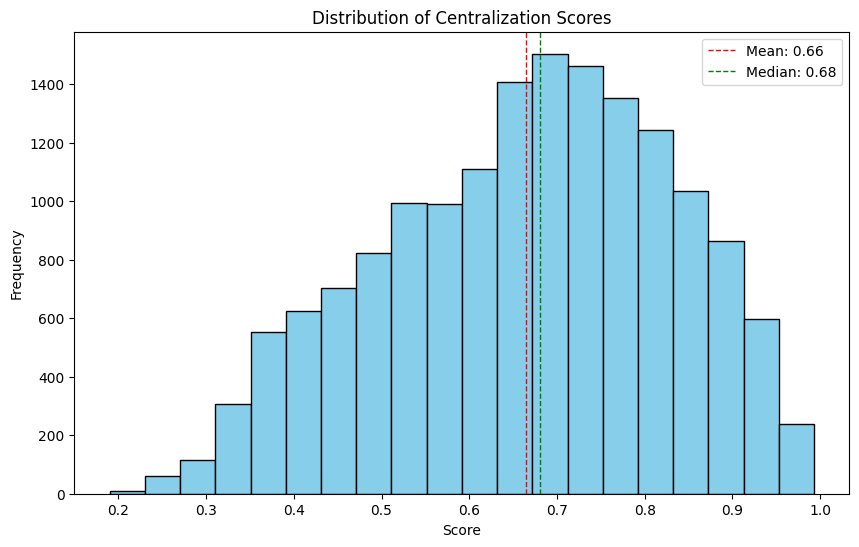

{'mean': np.float64(0.6649504234254349),
 'median': np.float64(0.6806685422317766),
 'std': np.float64(0.16480340835377408),
 'min': np.float64(0.19009343815720592),
 'max': np.float64(0.9930946603399752)}

In [64]:
bbox_coords = data_processor.get_bbox_coords(F_TRAIN_MASKS_POS)
centralization_scores = data_processor.generate_centralization_data(bbox_coords)
data_processor.visualize_centralization_scores(centralization_scores)

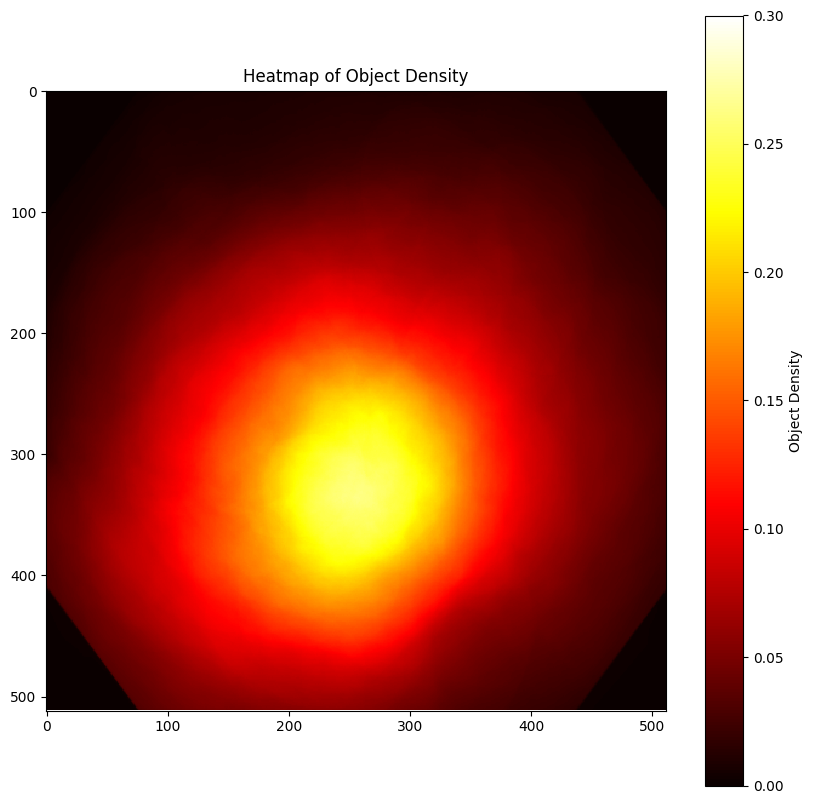

In [65]:
density_data = data_processor.generate_object_density_data(F_TRAIN_MASKS_POS)
data_processor.visualize_object_density(density_data)

### remove N most close-to-center frames

In [86]:
removed_center_close_images = data_processor.remove_highest_scored_images(centralization_scores, 4000)
data_processor.remove_files_by_base_names(F_TRAIN_IMAGES_POS, removed_center_close_images)

['./data/train/images/positive/case_M_20181031103335_0U62368103151535_1_006_001-1_a2_ayy_image0003.jpg',
 './data/train/images/positive/case_M_20181129152014_0U62366112981213_1_001_001-1_a21_ayy_image0024.jpg',
 './data/train/images/positive/case_M_20181001100941_0U62372100109341_1_005_001-1_a10_ayy_image0071.jpg',
 './data/train/images/positive/case_M_20190121095240_0U62368012118740_1_004_001-1_a1_ayy_image0060.jpg',
 './data/train/images/positive/case_M_20190109095638_0U62372010945338_1_003_001-1_a29_ayy_image0008.jpg',
 './data/train/images/positive/case_M_20190131094104_0U62367013193703_1_003_001-1_a8_ayy_image0115.jpg',
 './data/train/images/positive/case_M_20181119111911_0U62363111914011_1_005_001-1_a12_ayy_image0454.jpg',
 './data/train/images/positive/case_M_20181226125224_0U62363122631224_1_003_001-1_a10_ayy_image0270.jpg',
 './data/train/images/positive/case_M_20181207092523_0U62372120765622_1_005_001-1_a15_ayy_image0207.jpg',
 './data/train/images/positive/case_M_20190112093

##### analyze object density

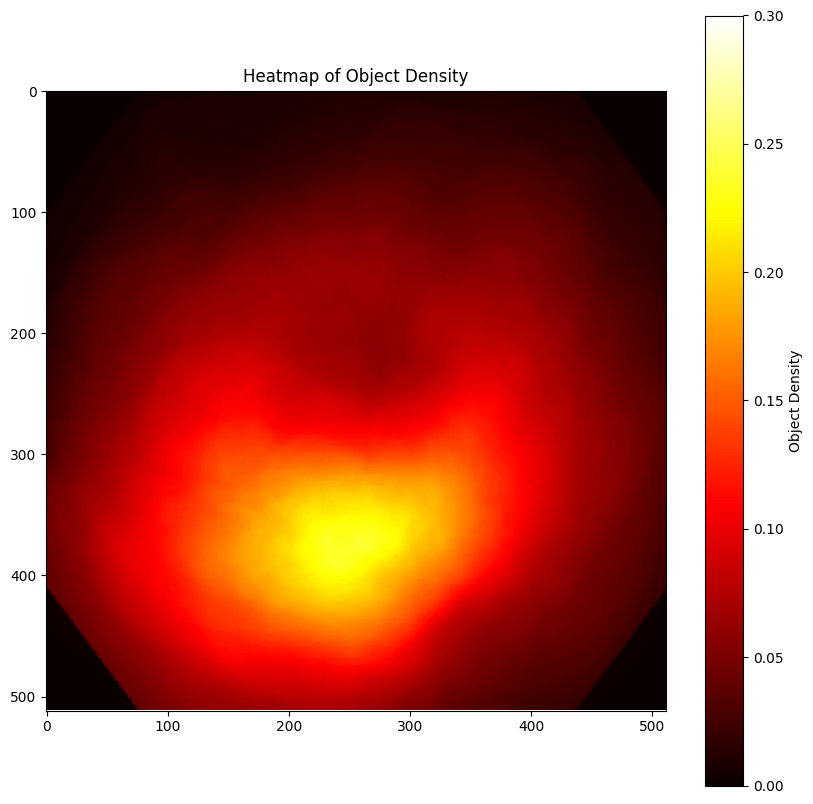

In [67]:
density_data = data_processor.generate_object_density_data(F_TRAIN_MASKS_POS)
data_processor.visualize_object_density(density_data)

### augment positive frames with flipping & rotating

In [ ]:
augmented_data = data_processor.augment_data_4x4_balance(F_TRAIN_MASKS_POS, 8000)
data_processor.apply_augmentations_to_matching_images(F_TRAIN_IMAGES_POS, augmented_data) 

##### analyze object density

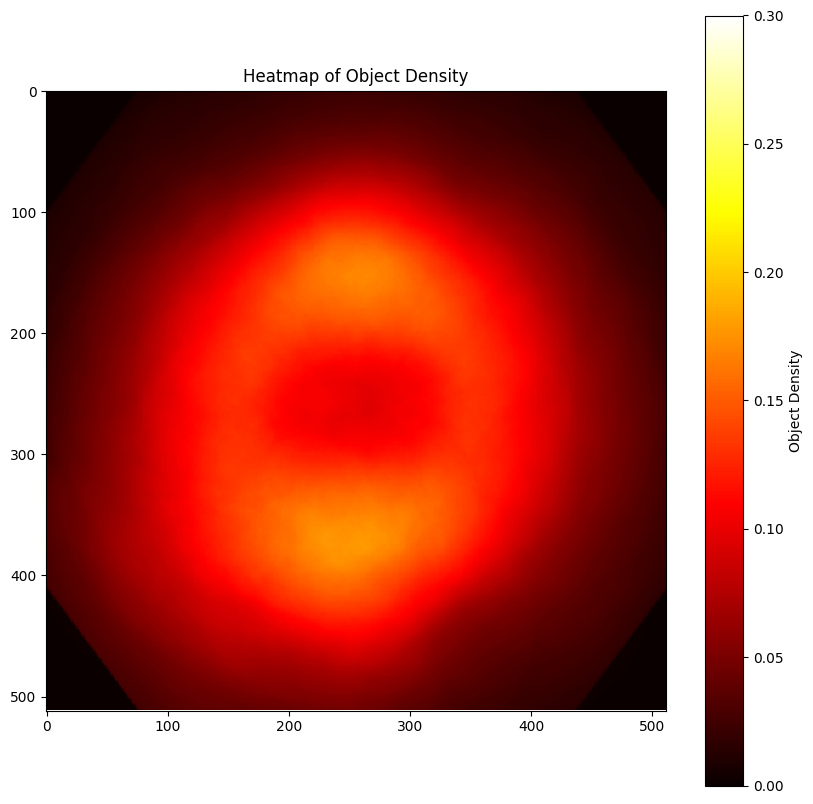

In [88]:
density_data = data_processor.generate_object_density_data(F_TRAIN_MASKS_POS)
data_processor.visualize_object_density(density_data)

### augment negative frames randomly

In [89]:
data_processor.augment_random_images(F_TRAIN_IMAGES_NEG, 2000)

### remove most abnormal frames

In [91]:
removed = data_processor.remove_most_abnormal(F_TRAIN_IMAGES_POS, 1380)
data_processor.remove_files_by_base_names(F_TRAIN_MASKS_POS, removed)

['./data/train/masks/positive/case_M_20190115123306_0U62368011540606_1_002_001-1_a3_ayy_image0033.png',
 './data/train/masks/positive/case_M_20190110094509_0U62363011095308_1_001_002-1_a2_ayy_image0023_flip_h.png',
 './data/train/masks/positive/case_M_20190107094528_0U62367010726528_1_002_001-1_a7_ayy_image0104.png',
 './data/train/masks/positive/case_M_20181214095357_0U62368121473456_1_006_003-1_a17_ayy_image0171_flip_h.png',
 './data/train/masks/positive/case_M_20181010094822_0U62363101085921_1_003_001-1_a15_ayy_image0169.png',
 './data/train/masks/positive/case_M_20181018093806_0U62363101890605_1_007_001-1_a1_ayy_image0087.png',
 './data/train/masks/positive/case_M_20181010094822_0U62363101085921_1_003_001-1_a17_ayy_image0103_flip_v.png',
 './data/train/masks/positive/case_M_20190117105747_0U62368011712547_1_002_001-1_a18_ayy_image0038.png',
 './data/train/masks/positive/case_M_20181019101517_0U62367101935917_1_003_001-1_a17_ayy_image0069.png',
 './data/train/masks/positive/case_M_2

In [92]:
data_processor.remove_most_abnormal(F_TRAIN_IMAGES_NEG, 1000)

['case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image005455.jpg',
 'case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image005455_rotate_90.jpg',
 'case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image005438_flip_h.jpg',
 'case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image005438.jpg',
 'case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image005669.jpg',
 'case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image008578.jpg',
 'case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image008561.jpg',
 'case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image008561_flip_v.jpg',
 'case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image005446.jpg',
 'case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image005446_rotate_180.jpg',
 'case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image008589.jpg',
 'case_M_20181109094641_0U62372110931241_

### analyze contrast

In [82]:
contrast_data = data_processor.analyze_contrast(F_TRAIN_IMAGES)

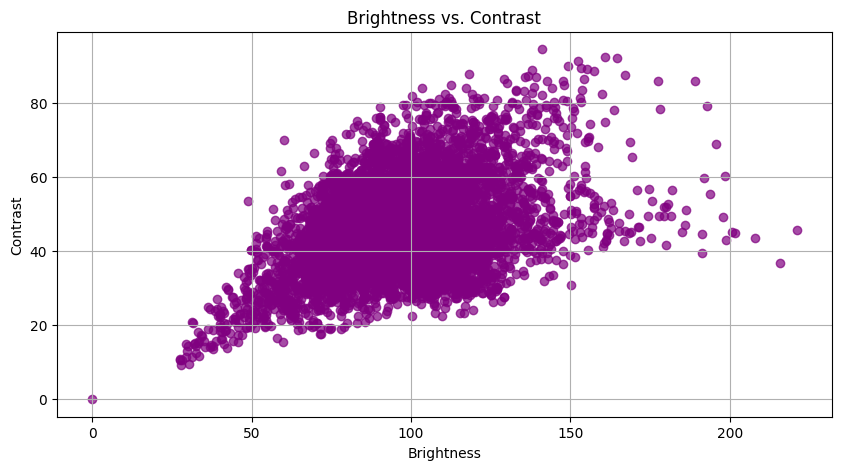

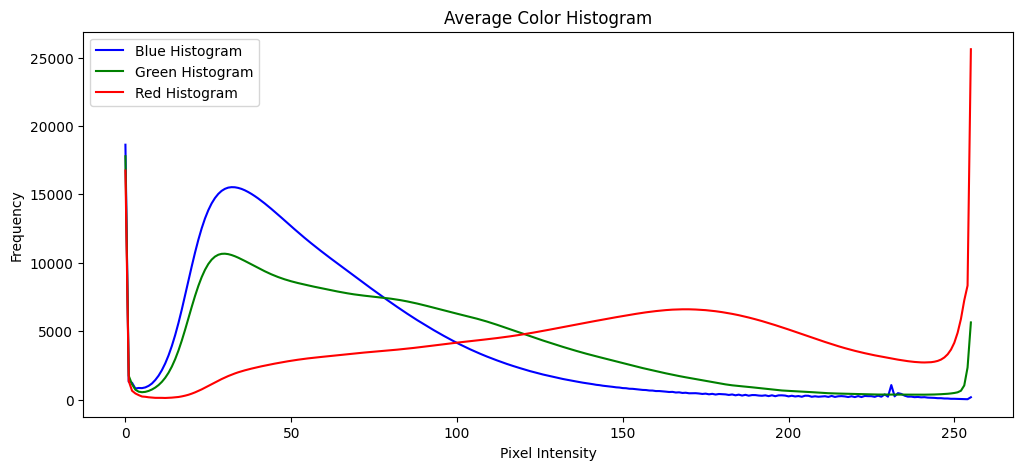

In [87]:
data_processor.visualize_contrast_analysis(contrast_data)

### analyze color

In [84]:
color_data = data_processor.analyze_color(F_TRAIN)

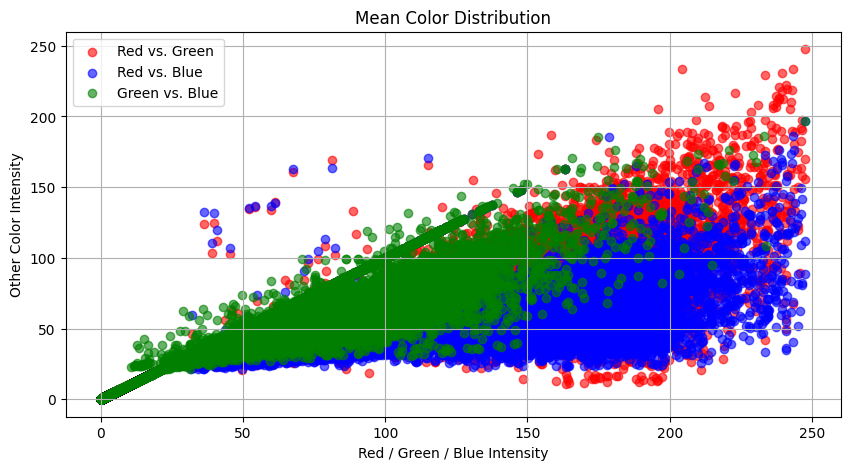

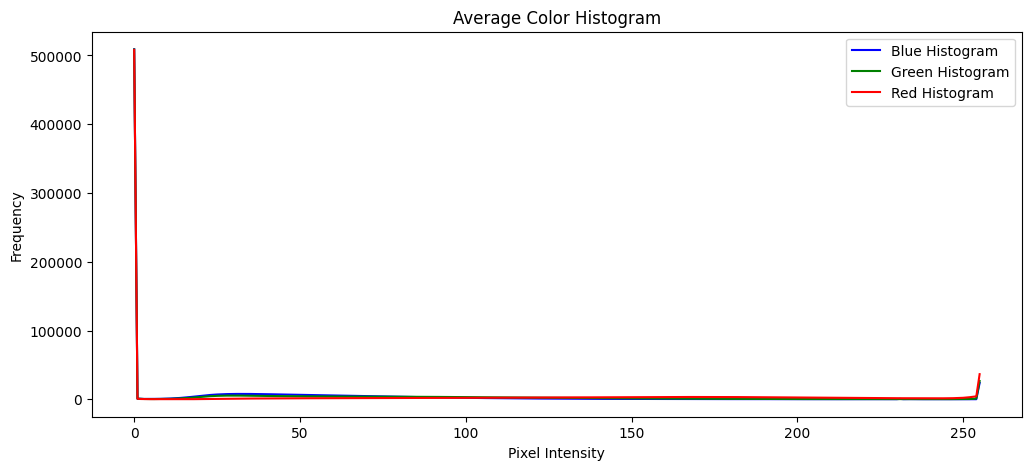

In [85]:
data_processor.visualize_color_analysis(color_data)

### merge other datasets

In [5]:
data_processor.crop_to_square(F_DATASETS)
data_processor.scale_images(F_DATASETS, (512, 512))

Square crop operation completed.
Processed: 0, Skipped (already square): 5152, Errors: 0
Scale operation completed.
Processed: 0, Skipped (already at target resolution): 5152, Errors: 0


{'processed': 0, 'errors': 0, 'skipped': 5152, 'total': 5152}

In [94]:
data_processor.copy_all_files(F_DATASET_1_IMAGES, F_TRAIN_IMAGES_POS)
data_processor.copy_all_files(F_DATASET_1_MASKS, F_TRAIN_MASKS_POS)
data_processor.copy_all_files(F_DATASET_2_IMAGES, F_TRAIN_IMAGES_POS)
data_processor.copy_all_files(F_DATASET_2_MASKS, F_TRAIN_MASKS_POS)

Copied: cvc_colodb_209.png
Copied: cvc_colodb_085.png
Copied: cvc_colodb_271.png
Copied: cvc_colodb_016.png
Copied: cvc_colodb_109.png
Copied: cvc_colodb_328.png
Copied: cvc_colodb_035.png
Copied: cvc_colodb_137.png
Copied: cvc_colodb_348.png
Copied: cvc_colodb_105.png
Copied: cvc_colodb_301.png
Copied: cvc_colodb_296.png
Copied: cvc_colodb_195.png
Copied: cvc_colodb_136.png
Copied: cvc_colodb_185.png
Copied: cvc_colodb_249.png
Copied: cvc_colodb_129.png
Copied: cvc_colodb_134.png
Copied: cvc_colodb_155.png
Copied: cvc_colodb_361.png
Copied: cvc_colodb_188.png
Copied: cvc_colodb_261.png
Copied: cvc_colodb_380.png
Copied: cvc_colodb_378.png
Copied: cvc_colodb_213.png
Copied: cvc_colodb_236.png
Copied: cvc_colodb_295.png
Copied: cvc_colodb_170.png
Copied: cvc_colodb_270.png
Copied: cvc_colodb_115.png
Copied: cvc_colodb_037.png
Copied: cvc_colodb_138.png
Copied: cvc_colodb_103.png
Copied: cvc_colodb_174.png
Copied: cvc_colodb_288.png
Copied: cvc_colodb_244.png
Copied: cvc_colodb_303.png
C

### validation split

In [97]:
moved = data_processor.move_random_n_images(F_TRAIN_IMAGES_POS, F_VAL_IMAGES_POS, 4000)
data_processor.move_images_by_name(F_TRAIN_MASKS_POS, F_VAL_MASKS_POS, moved)

['case_M_20181010094822_0U62363101085921_1_003_001-1_a4_ayy_image0007.png',
 'case_M_20190128094801_0U62372012857800_1_002_001-1_a6_ayy_image0009.png',
 'case_M_20190110094509_0U62363011095308_1_001_002-1_a2_ayy_image0077_flip_v.png',
 'case_M_20181010094822_0U62363101085921_1_003_001-1_a1_ayy_image0227_flip_v.png',
 'case_M_20181017100226_0U62367101735926_1_007_004-1_a6_ayy_image0013.png',
 'case_M_20181226125224_0U62363122631224_1_003_001-1_a5_ayy_image0162.png',
 'case_M_20181010094822_0U62363101085921_1_003_001-1_a1_ayy_image0168_flip_h.png',
 'case_M_20181213131150_0U62365121395349_1_002_002-1_a18_ayy_image0044.png',
 'case_M_20181025095048_0U62372102595347_1_004_001-1_a17_ayy_image0092.png',
 'case_M_20181217131216_0U62368121700016_1_002_001-1_a10_ayy_image0166.png',
 'case_M_20181015101337_0U62363101576536_1_005_001-1_a21_ayy_image0267_flip_h.png',
 'case_M_20181217131216_0U62368121700016_1_002_001-1_a10_ayy_image0041_flip_h.png',
 'case_M_20181119111911_0U62363111914011_1_005_0

In [98]:
data_processor.move_random_n_images(F_TRAIN_IMAGES_NEG, F_VAL_IMAGES_NEG, 1000)

['case_M_20181109094641_0U62372110931241_1_007_001-1_Negative_ayy_image007679.jpg',
 'case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image003660.jpg',
 'case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image003540.jpg',
 'case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image007936.jpg',
 'case_M_20181109094641_0U62372110931241_1_007_001-1_Negative_ayy_image002799_rotate_90.jpg',
 'case_M_20181109094641_0U62372110931241_1_003_001-1_Negative_ayy_image000110_rotate_270.jpg',
 'case_M_20181109094641_0U62372110931241_1_007_001-1_Negative_ayy_image001332_flip_h.jpg',
 'case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image000293.jpg',
 'case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image001814.jpg',
 'case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image007201.jpg',
 'case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image003337.jpg',
 'case_M_20181024134247_0U62368102492146_1_002_0

### save polygon coordinates

In [102]:
data_processor.masks_to_polygons(F_TRAIN_IMAGES_POS, F_TRAIN_MASKS_POS, F_TRAIN_LABELS)
data_processor.create_empty_text_files(F_TRAIN_IMAGES_NEG, F_TRAIN_LABELS)
data_processor.masks_to_polygons(F_VAL_IMAGES_POS, F_VAL_MASKS_POS, F_VAL_LABELS)
data_processor.create_empty_text_files(F_VAL_IMAGES_NEG, F_VAL_LABELS)

Skipping invalid contour in case_M_20181001140915_0U62366100164014_1_001_001-1_a4_ayy_image0046_rotate_180.png
Skipping invalid contour in case_M_20181119111911_0U62363111914011_1_005_001-1_a12_ayy_image0060_flip_v.png
Skipping invalid contour in case_M_20181119111911_0U62363111914011_1_005_001-1_a12_ayy_image0060_flip_v.png
Skipping invalid contour in case_M_20181119111911_0U62363111914011_1_005_001-1_a12_ayy_image0060_flip_v.png
Skipping invalid contour in case_M_20181119111911_0U62363111914011_1_005_001-1_a12_ayy_image0060_flip_v.png
Skipping invalid contour in case_M_20181119111911_0U62363111914011_1_005_001-1_a16_ayy_image0231_flip_v.png
Skipping invalid contour in case_M_20181119111911_0U62363111914011_1_005_001-1_a16_ayy_image0231_flip_v.png
Skipping invalid contour in case_M_20181119111911_0U62363111914011_1_005_001-1_a16_ayy_image0231_flip_v.png
Skipping invalid contour in case_M_20181119111911_0U62363111914011_1_005_001-1_a16_ayy_image0231_flip_v.png
Skipping invalid contour 

#### check

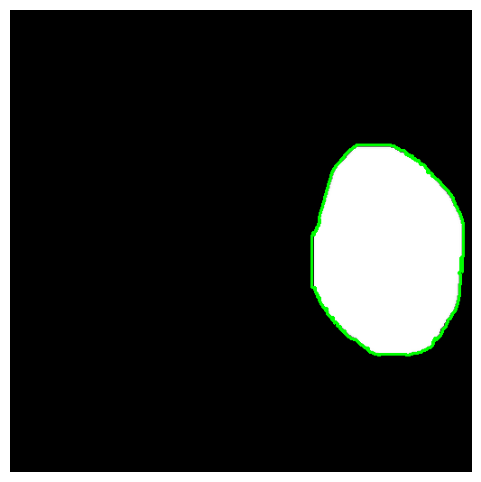

In [22]:
data_processor.visualize_polygon(F_TRAIN_MASKS_POS, F_TRAIN_LABELS)

### create empty masks in train and val

In [12]:
data_processor.create_empty_masks(F_TRAIN_IMAGES_NEG, F_TRAIN_MASKS_NEG, data_processor.mask_extension)
data_processor.create_empty_masks(F_VAL_IMAGES_NEG, F_VAL_MASKS_NEG, data_processor.mask_extension)

Clearing existing directory: ./data/train/masks/negative
Analyzing image resolutions...
Found 1 unique resolutions across 4000 images
Creating template black images...
Created template black image: 512x512
Generating output images...
Progress: 50 images created
Progress: 100 images created
Progress: 150 images created
Progress: 200 images created
Progress: 250 images created
Progress: 300 images created
Progress: 350 images created
Progress: 400 images created
Progress: 450 images created
Progress: 500 images created
Progress: 550 images created
Progress: 600 images created
Progress: 650 images created
Progress: 700 images created
Progress: 750 images created
Progress: 800 images created
Progress: 850 images created
Progress: 900 images created
Progress: 950 images created
Progress: 1000 images created
Progress: 1050 images created
Progress: 1100 images created
Progress: 1150 images created
Progress: 1200 images created
Progress: 1250 images created
Progress: 1300 images created
Progre

{'total_processed': 1000,
 'unique_resolutions': 1,
 'created_images': 1000,
 'skipped_files': []}

### mix positive and negatives in train and val

In [14]:
data_processor.flatten_directory(F_TRAIN_IMAGES)
data_processor.flatten_directory(F_TRAIN_MASKS)
data_processor.flatten_directory(F_VAL_IMAGES)
data_processor.flatten_directory(F_VAL_MASKS)

## trying stuff

In [ ]:
data_processor.compare_filenames(F_TRAIN_MASKS, F_TRAIN_LABELS)

In [24]:
data_processor.recreate_images_from_arrays(F_TEST)